## Importing Libraries

In [1]:
from unet import Unet 
import numpy as np
import matplotlib.pyplot as plt
from monai.data import DataLoader,Dataset
from torch import (from_numpy,device, set_float32_matmul_precision)
from warnings import filterwarnings
from os.path import join,exists,expanduser
from os import listdir,mkdir
from pytorch_lightning import LightningModule, Trainer
from torch import argmax
import pandas as pd
from Utils import gain_functions,plotting_functions,shift_function

In [2]:
set_float32_matmul_precision('high')
filterwarnings('ignore')

## Loading Labels

In [6]:
train_dir = '/mnt/camobi_1/romulo_files/pytorch_unet/CNN_FP/Dados'
traces_arr = np.load(join(train_dir,'dataset_train.npz'))['arr_0']
labels_arr = np.load(join(train_dir,'dataset_train.npz'))['arr_1']

print(f'Input Shape: {traces_arr.shape}')
print(f'Labels Shape: {labels_arr.shape}')

Input Shape: (19560, 1001)
Labels Shape: (19560, 1001)


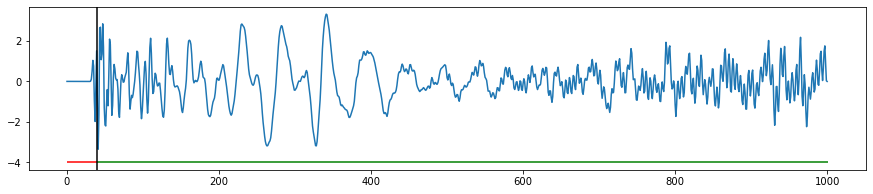

In [7]:
idx=2
plt.figure(figsize=(15,3))
plt.plot(traces_arr[idx])
plt.axvline(x=np.argmax(labels_arr[idx]), color='black')
plt.hlines(y=-4,xmin=0, xmax=np.argmax(labels_arr[idx]), colors='red')
plt.hlines(y=-4, xmin=np.argmax(labels_arr[idx]), xmax = traces_arr.shape[1], colors='green')
plt.show()

## Loading Prediction Data

In [3]:
pred_dir = 'D:\Dados_TCC\Dados_pred'
csv_file = [join(pred_dir,file) for file in listdir(pred_dir) if file.endswith('csv')]
dataset = pd.read_csv(csv_file[0])
dataset

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,992,993,994,995,996,997,998,999,1000,N_tiro
0,0,-4.768662e-07,-5.960828e-07,1.192166e-07,5.960828e-07,-1.192166e-07,-7.152993e-07,-1.192166e-07,5.960828e-07,4.768662e-07,...,2.095868e-08,5.029126e-08,-8.708855e-08,-2.696396e-07,-6.005286e-08,-5.988536e-07,-5.522947e-07,8.847627e-08,-4.261002e-07,18
1,1,2.375194e-07,-1.187597e-07,2.375194e-07,4.750388e-07,0.000000e+00,2.375194e-07,1.187597e-07,2.375194e-07,3.562791e-07,...,-2.793960e-07,-4.940434e-07,2.421344e-07,-3.255137e-07,-5.401612e-07,-6.146843e-08,-9.781155e-08,-1.941798e-07,-2.863816e-07,18
2,2,4.768662e-07,1.430599e-06,4.768662e-07,1.192166e-07,2.503548e-06,4.291796e-06,4.291796e-06,4.768663e-06,6.318477e-06,...,7.289812e-06,2.720513e-06,2.068888e-07,3.073508e-06,7.229784e-06,8.485464e-06,4.380154e-06,1.544116e-07,-1.021940e-08,18
3,3,8.372444e-08,8.372444e-08,8.372444e-08,0.000000e+00,-8.372444e-08,0.000000e+00,0.000000e+00,-8.372444e-08,-8.372444e-08,...,3.939321e-07,3.492270e-07,2.980033e-07,2.300441e-07,2.649483e-07,1.932444e-07,1.173336e-07,1.588026e-07,6.425353e-08,18
4,4,-2.102857e-07,2.102857e-07,-1.051429e-07,-3.154286e-07,-2.102857e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.950958e-07,-7.452763e-08,4.018773e-07,1.075786e-07,-9.639439e-08,1.573807e-07,2.067313e-07,2.873274e-07,2.160618e-07,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101681,101681,-7.554508e-09,-2.313376e-08,-1.510902e-08,3.304304e-09,1.180290e-08,4.720434e-09,6.138379e-09,2.077354e-08,2.502375e-08,...,1.789340e-07,2.100965e-07,2.540019e-07,2.653422e-07,2.752532e-07,2.842160e-07,2.440908e-07,1.784665e-07,8.687812e-08,375
101682,101682,-1.414573e-08,2.074961e-08,1.461829e-08,1.226027e-08,3.112204e-08,1.084499e-08,-4.243482e-09,-1.415286e-09,-3.300751e-09,...,4.805120e-07,5.064568e-07,4.956100e-07,4.649450e-07,4.743852e-07,4.800431e-07,4.753230e-07,4.904210e-07,4.941995e-07,375
101683,101683,-9.856265e-09,-4.224113e-09,-2.205837e-08,9.391359e-10,1.361014e-08,-9.391359e-10,1.548842e-08,1.408038e-09,-1.689645e-08,...,1.145239e-07,1.140486e-07,8.213232e-08,4.927938e-08,3.894819e-08,3.755019e-08,8.917823e-08,1.051293e-07,1.253121e-07,375
101684,101684,-5.144387e-08,-1.076054e-07,4.153370e-08,1.368612e-07,2.643108e-08,-5.568685e-08,4.717716e-09,5.474331e-08,-5.192455e-09,...,-1.552631e-07,-4.422143e-07,-5.951137e-07,-4.016206e-07,-1.713156e-07,-1.297765e-07,-3.066622e-08,2.656985e-07,4.025680e-07,375


In [4]:
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,1000,N_tiro
0,-4.768662e-07,-5.960828e-07,1.192166e-07,5.960828e-07,-1.192166e-07,-7.152993e-07,-1.192166e-07,5.960828e-07,4.768662e-07,-2.384331e-07,...,2.095868e-08,5.029126e-08,-8.708855e-08,-2.696396e-07,-6.005286e-08,-5.988536e-07,-5.522947e-07,8.847627e-08,-4.261002e-07,18
1,2.375194e-07,-1.187597e-07,2.375194e-07,4.750388e-07,0.000000e+00,2.375194e-07,1.187597e-07,2.375194e-07,3.562791e-07,-2.375194e-07,...,-2.793960e-07,-4.940434e-07,2.421344e-07,-3.255137e-07,-5.401612e-07,-6.146843e-08,-9.781155e-08,-1.941798e-07,-2.863816e-07,18
2,4.768662e-07,1.430599e-06,4.768662e-07,1.192166e-07,2.503548e-06,4.291796e-06,4.291796e-06,4.768663e-06,6.318477e-06,8.464375e-06,...,7.289812e-06,2.720513e-06,2.068888e-07,3.073508e-06,7.229784e-06,8.485464e-06,4.380154e-06,1.544116e-07,-1.021940e-08,18
3,8.372444e-08,8.372444e-08,8.372444e-08,0.000000e+00,-8.372444e-08,0.000000e+00,0.000000e+00,-8.372444e-08,-8.372444e-08,-8.372444e-08,...,3.939321e-07,3.492270e-07,2.980033e-07,2.300441e-07,2.649483e-07,1.932444e-07,1.173336e-07,1.588026e-07,6.425353e-08,18
4,-2.102857e-07,2.102857e-07,-1.051429e-07,-3.154286e-07,-2.102857e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.102857e-07,...,-1.950958e-07,-7.452763e-08,4.018773e-07,1.075786e-07,-9.639439e-08,1.573807e-07,2.067313e-07,2.873274e-07,2.160618e-07,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101681,-7.554508e-09,-2.313376e-08,-1.510902e-08,3.304304e-09,1.180290e-08,4.720434e-09,6.138379e-09,2.077354e-08,2.502375e-08,1.180290e-08,...,1.789340e-07,2.100965e-07,2.540019e-07,2.653422e-07,2.752532e-07,2.842160e-07,2.440908e-07,1.784665e-07,8.687812e-08,375
101682,-1.414573e-08,2.074961e-08,1.461829e-08,1.226027e-08,3.112204e-08,1.084499e-08,-4.243482e-09,-1.415286e-09,-3.300751e-09,-7.074057e-09,...,4.805120e-07,5.064568e-07,4.956100e-07,4.649450e-07,4.743852e-07,4.800431e-07,4.753230e-07,4.904210e-07,4.941995e-07,375
101683,-9.856265e-09,-4.224113e-09,-2.205837e-08,9.391359e-10,1.361014e-08,-9.391359e-10,1.548842e-08,1.408038e-09,-1.689645e-08,1.595732e-08,...,1.145239e-07,1.140486e-07,8.213232e-08,4.927938e-08,3.894819e-08,3.755019e-08,8.917823e-08,1.051293e-07,1.253121e-07,375
101684,-5.144387e-08,-1.076054e-07,4.153370e-08,1.368612e-07,2.643108e-08,-5.568685e-08,4.717716e-09,5.474331e-08,-5.192455e-09,-4.483314e-08,...,-1.552631e-07,-4.422143e-07,-5.951137e-07,-4.016206e-07,-1.713156e-07,-1.297765e-07,-3.066622e-08,2.656985e-07,4.025680e-07,375


In [5]:
type(dataset)

pandas.core.frame.DataFrame

In [6]:
pred_dataset = gain_functions.spherical_divergence(dataset,pred_dir,plotting=False,pred_data=True)
pred_data_plot = pred_dataset

#Normalizing Data
pred_dataset.std(axis=1).shape
pred_dataset = (pred_dataset.T/pred_dataset.std(axis=1)).T
#Putting on Torch format
pred_dataset = from_numpy(np.float32(pred_dataset[:,None,:]))
# pred_dataset = from_numpy(np.float32(pred_dataset))
print(f'Prediction Data Shape: {pred_dataset.shape}')
print(f'Prediciton Data Type:{pred_dataset.dtype}')

Prediction Data Shape: torch.Size([101686, 1, 1001])
Prediciton Data Type:torch.float32


In [7]:
#creating a dataloader for prediction
pred_ds = Dataset(data=pred_dataset, transform = None)
pred_loader = DataLoader(pred_ds,batch_size=1000, shuffle=False,
                          num_workers = 16, pin_memory=False, drop_last = False)

In [9]:
model_dir = r'D:\Dados_TCC\Notebooks\Modelo_com_shift_and_spherical_divergence'

In [10]:
model_file = [join(model_dir,file) for file in listdir(model_dir) if file.endswith('ckpt')]
model_file

['D:\\Dados_TCC\\Notebooks\\Modelo_com_shift_and_spherical_divergence\\model.ckpt']

## Prediction

In [11]:
#Defining model
model = Unet()
#predicting with the model
modelo = model.load_from_checkpoint(model_file[0])
trainer_pred = Trainer() #  accelerator='gpu', devices=[1] or 0
predict_step = trainer_pred.predict(modelo, pred_loader)

2023-11-02 18:18:59,755 - GPU available: False, used: False
2023-11-02 18:18:59,858 - TPU available: False, using: 0 TPU cores
2023-11-02 18:18:59,858 - IPU available: False, using: 0 IPUs
2023-11-02 18:18:59,860 - HPU available: False, using: 0 HPUs
2023-11-02 18:18:59,865 - Missing logger folder: D:\Dados_TCC\Notebooks\lightning_logs


Predicting: 0it [00:00, ?it/s]

In [14]:
#joining all prediction images on a unique list and transform on tensor
total_predictions = []

for pred_loader in predict_step:
    for pred_tns in pred_loader:
        total_predictions.append(np.asarray(pred_tns))
        
print(f'Predictions Size: {len(total_predictions)}')
total_pred = np.asarray(total_predictions).reshape(237687, 1001)
total_pred=np.where(total_pred<0.5,0,1)

Predictions Size: 237687


## Plotting with plt.imshow()

In [15]:
#numero dos tiros
tiros = []
for i in dataset.loc[:,'N_tiro']:
    tiros.append(i)
valores_tiros = np.unique(tiros)
print(valores_tiros)

[ 18  19  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 174 175 176 177 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 246 247 248 249 250 251 253 254 255 256 258 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 27

In [16]:
#Mudando o nome das colunas de str para int
list_idx = [idx for idx in dataset.columns]
list_idx.pop(-1)
list_idx_int = [int(idx) for idx in list_idx]
list_idx_int.append('N_tiro')

In [17]:
#Mudando o nome das colunas de str para int
dataset.columns = list_idx_int

(400, 0)

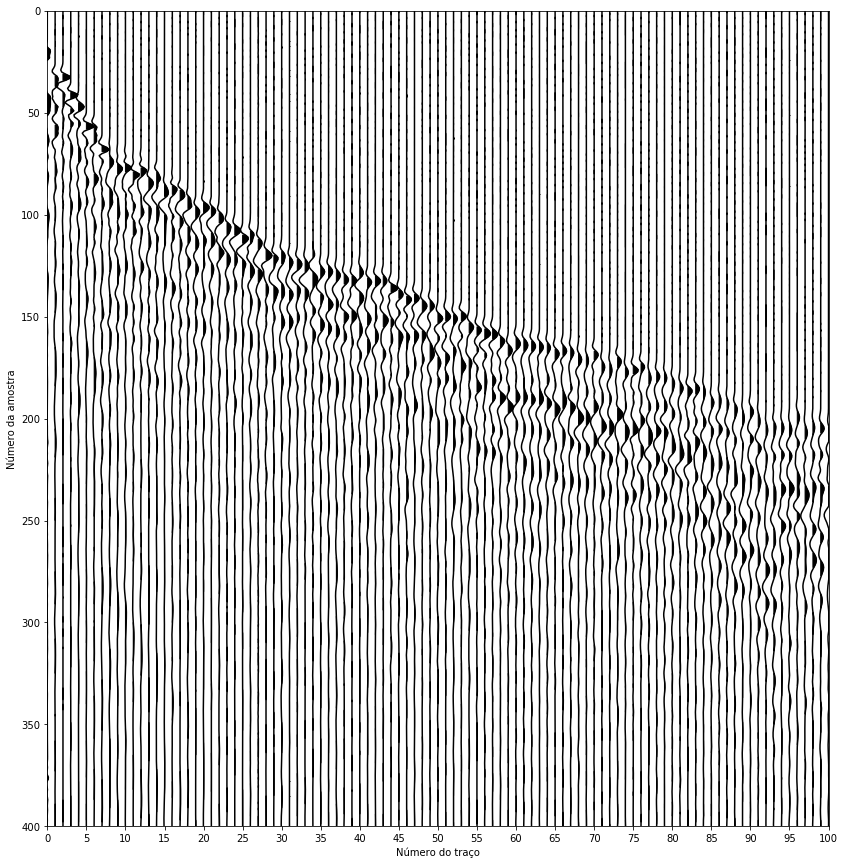

In [24]:
# plotting_functions.wigle_plot(dataset[dataset.N_tiro==25][np.arange(0,1001)].values,0,
#                               dataset[dataset.N_tiro==25][np.arange(0,1001)].shape[0],fat=15)

# plt.xlim(0,100*15)
# plt.ylim(400,0)

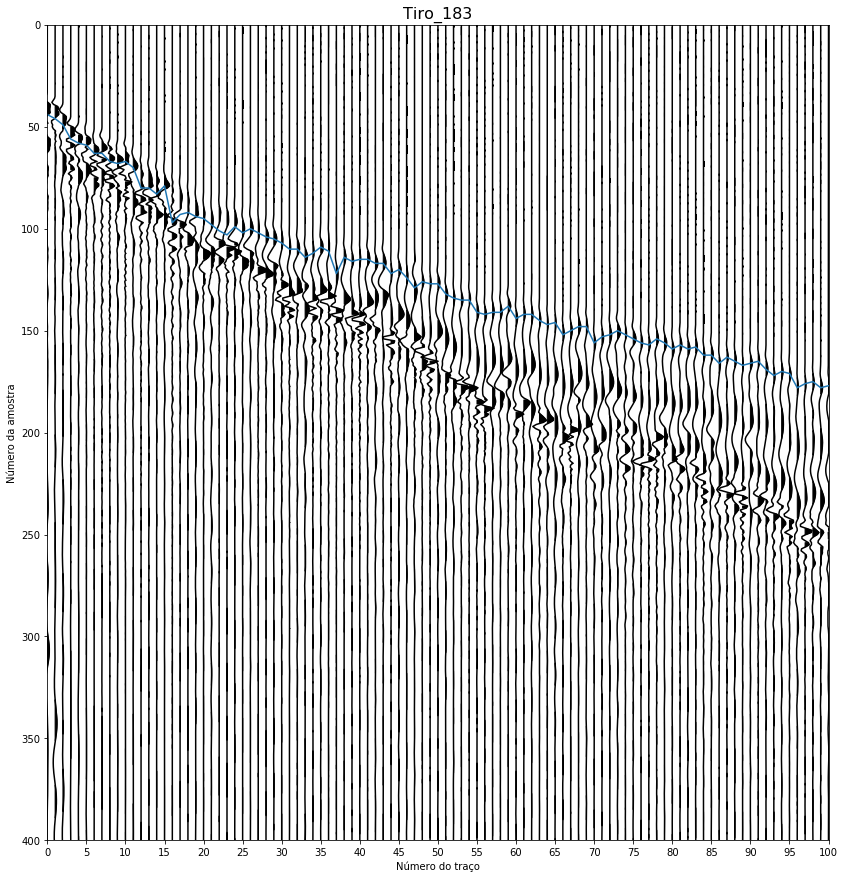

In [26]:
plotting_functions.plot_wigle_tiro(pred_dataset=dataset, predictions=total_pred,
                             number_tiro = 183, save=False, fat=15)

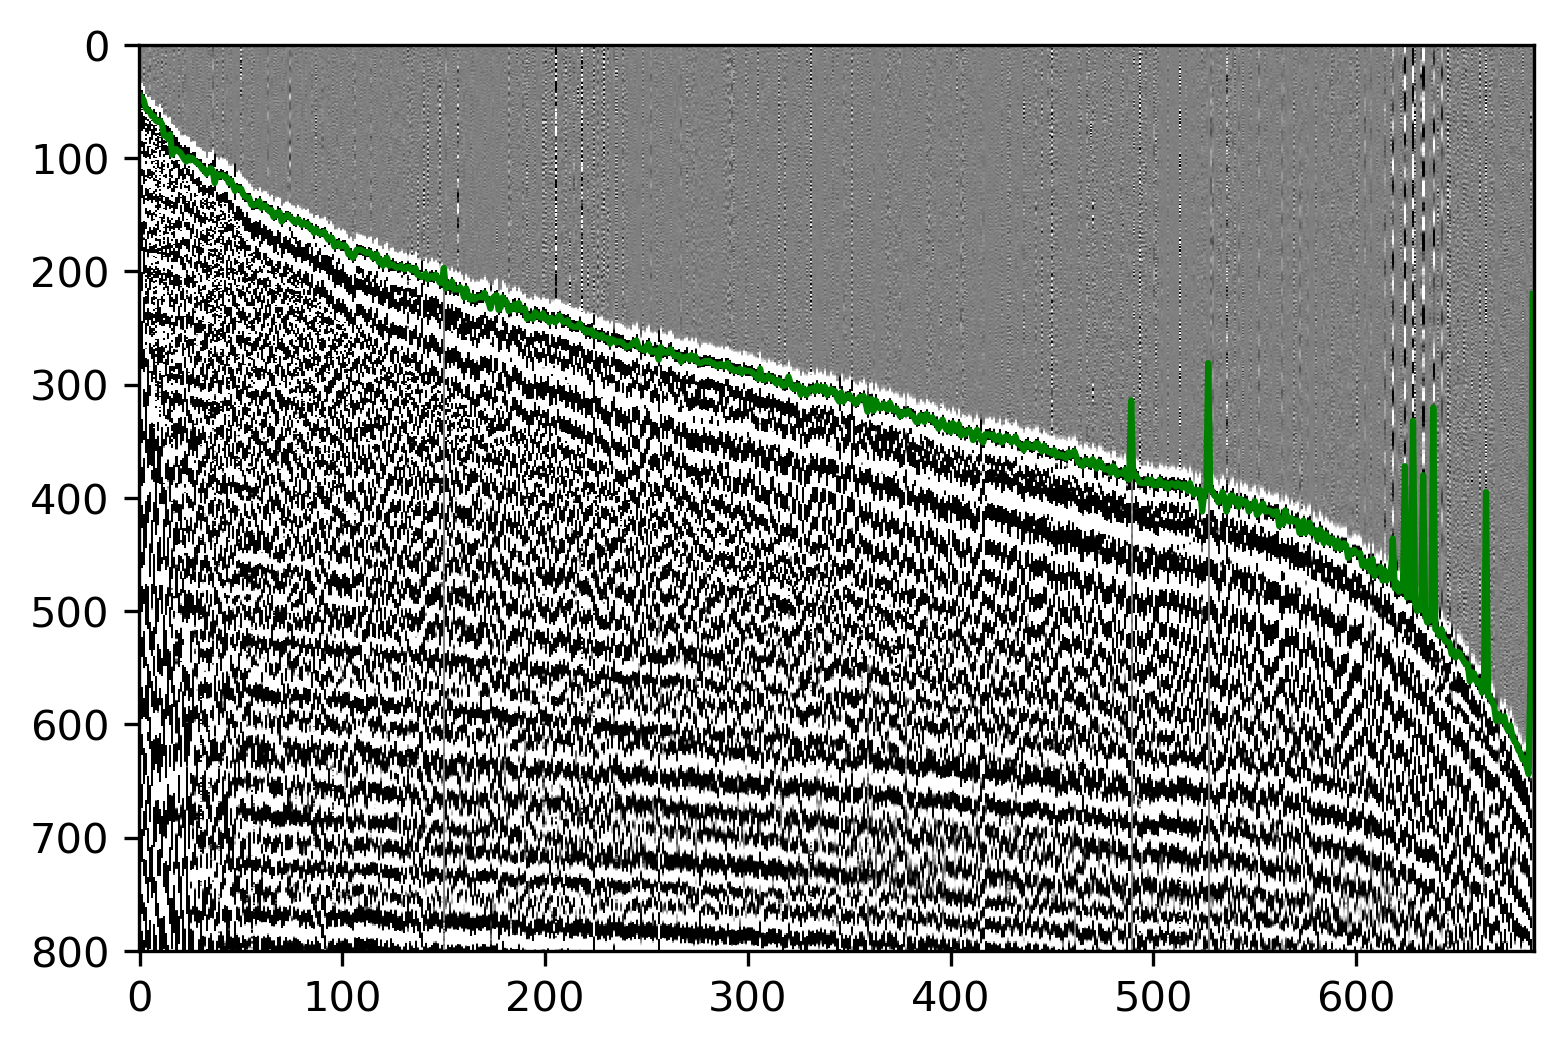

In [27]:
plotting_functions.plot_tiro(pred_dataset=dataset, predictions=total_pred,
                             number_tiro = 183, save=False)

## Plotting Prediction

In [ ]:
# for i in range(0,200): #20100,20150
#     fig,ax = plt.subplots(figsize=(15,2))
    
#     ax.plot(pred_data_plot[i], color='black')
    
#     ax.axvline(x=np.argmax(total_pred[i]), color='red')
#     ax.axvline(x=np.argmax(labels_arr[i]), color='green') #label
    
#     ax.set_xlim([0,500])
    
#     ax.set_xlabel('N° da Amostra')
#     ax.set_ylabel('Y-axis')
#     ax.set_title('Vertical Trace')
    
#     plt.show()
# #     fig.savefig(f'amostra_{i}.png', transparent=False)